# Simulating Spectra for the JWST/ETC

The goal of this notebook is to build a handful of "truth" spectra that we can simulate using the [JWST Exposure Time Calculator](https://jwst.etc.stsci.edu).

In [1]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, Column
from astropy.io import fits

from sedpy.observate import load_filters
from prospect.sources import CSPSpecBasis

In [2]:
%matplotlib inline

In [3]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

### Initialize the SSPs.

In [4]:
t0 = time.time()
print('Initializing CSPSpecBasis...')
sps = CSPSpecBasis(zcontinuous=1, compute_vega_mags=False, vactoair_flag=False)
print('...took {:.1f} seconds.'.format(time.time() - t0)) 

Initializing CSPSpecBasis...
...took 11.3 seconds.


### Define the sample and physical properties of the "galaxies" to simulate.

Six models, all with 10^11 Msun.
* tau=0, Z=Zsun, z=1.5
* tau=0, Z=Zsun, z=2.5
* tau=3, Z=Zsun, z=1.5
* tau=3, Z=Zsun, z=2.5
* tau=0, Z=0.2Zsun, z=1.5
* tau=3, Z=0.2Zsun, z=1.5

Figures:
* 2-panel with input photometry and SED and maximum likelihood
* triangle plot

* [8/5/17, 10:20:57 AM] Anthony H Gonzalez: Properties to check: Stellar Mass, Age, Metallicity
* [8/5/17, 10:23:00 AM] Anthony H Gonzalez: Filters: z<2   F2100W, F444W, F277W, F150W, F090W
* [8/5/17, 10:23:19 AM] Anthony H Gonzalez: z>2: F2550W, F444W, F277W, F150W, F090W
* [8/5/17, 10:24:48 AM] Anthony H Gonzalez: Adam had calculated for 1200S SNR=6 at L below 4000A break, For F150W, F277W, F444W the SNR is very high (20 at L*+3 in 2 min), For MIRI, baseline SNR=7 for L.
* [8/5/17, 10:25:36 AM] Anthony H Gonzalez: …actually, I went back for NIRCam and we set it to SNR=5 at M*+2

In [5]:
nspec = 6
npix = len(sps.csp.wavelengths)
jwstdir = os.path.join( os.getenv('IM_PROJECTS_DIR'), 'jwstclusters', 'etc', 'input' )

In [6]:
band = ['F2100W', 'F444W', 'F277W', 'F150W', 'F090W', 
        'F2550W', 'F444W', 'F277W', 'F150W', 'F090W']
filternames = ['jwst_{}'.format(bb.lower()) for bb in band]
nfilt = len(band)
print(filternames)

['jwst_f2100w', 'jwst_f444w', 'jwst_f277w', 'jwst_f150w', 'jwst_f090w', 'jwst_f2550w', 'jwst_f444w', 'jwst_f277w', 'jwst_f150w', 'jwst_f090w']


In [7]:
cat = Table()
cat.add_column(Column(name='WAVELENGTH', shape=(npix,), length=nspec, 
                      dtype='f4', unit=u.micron))
cat.add_column(Column(name='FLUX', shape=(npix,), length=nspec, dtype='f4', unit=u.mJy))
cat.add_column(Column(name='ID', length=nspec, dtype='i4'))
cat.add_column(Column(name='ZRED', length=nspec, dtype='f4'))  # observed redshift
cat.add_column(Column(name='ZFORM', length=nspec, dtype='f4')) # formation redshift
cat.add_column(Column(name='LOGMASS', length=nspec, dtype='f4', unit=u.solMass))
cat.add_column(Column(name='LOGZSOL', length=nspec, dtype='f4'))
cat.add_column(Column(name='TAU', length=nspec, dtype='f4', unit=u.Gyr))
cat.add_column(Column(name='TAGE', length=nspec, dtype='f4', unit=u.Gyr))
cat.add_column(Column(name='ABMAG', length=nspec, shape=(nfilt,), dtype='f4'))

In [8]:
cat['ID'] = np.arange(nspec)
cat['LOGMASS'] = np.array([11, 11, 11, 11, 11, 11]).astype('f4') * u.solMass
cat['TAU'] = np.array([0.01, 0.01, 3, 3, 0.01, 3]).astype('f4') * u.Gyr
cat['LOGZSOL'] = np.log10( np.array([1, 1, 1, 1, 0.2, 0.2]) ).astype('f4')
cat['ZRED'] = [1.5, 2.5, 1.5, 2.5, 1.5, 1.5]
cat['ZFORM'] = 5.0 # fixed formation redshift
cat['TAGE'] = (cosmo.age(cat['ZRED']) - cosmo.age(cat['ZFORM'])).astype('f4')
cat

WAVELENGTH [5994],FLUX [5994],ID,ZRED,ZFORM,LOGMASS,LOGZSOL,TAU,TAGE,ABMAG [10]
micron,mJy,,,,solMass,,Gyr,Gyr,
float32,float32,int64,float64,float32,float32,float32,float32,float32,float32
0.0 .. 0.0,0.0 .. 0.0,0,1.5,5.0,11.0,0.0,0.01,3.04597,0.0 .. 0.0
0.0 .. 0.0,0.0 .. 0.0,1,2.5,5.0,11.0,0.0,0.01,1.41879,0.0 .. 0.0
0.0 .. 0.0,0.0 .. 0.0,2,1.5,5.0,11.0,0.0,3.0,3.04597,0.0 .. 0.0
0.0 .. 0.0,0.0 .. 0.0,3,2.5,5.0,11.0,0.0,3.0,1.41879,0.0 .. 0.0
0.0 .. 0.0,0.0 .. 0.0,4,1.5,5.0,11.0,-0.69897,0.01,3.04597,0.0 .. 0.0
0.0 .. 0.0,0.0 .. 0.0,5,1.5,5.0,11.0,-0.69897,3.0,3.04597,0.0 .. 0.0


In [9]:
def logmass2mass(logmass=11.0, **extras):
    return 10**logmass

In [10]:
def load_model(cat):
    """Load the model parameters. For more documentation see
    http://dan.iel.fm/python-fsps/current/stellarpop_api/#api-reference

    """
    from prospect.models import priors, sedmodel

    model_params = []

    ##################################################
    # Fixed priors

    # Galaxy redshift
    model_params.append({
        'name': 'zred',
        'N': 1,
        'isfree': False,
        'init': cat['ZRED'],
        'prior': None,       
        })

    model_params.append({ # current mass in stars, not integral of SFH
        'name': 'mass_units',
        'N': 1,
        'isfree': False,
        'init': 'mstar', # 'mformed'
        'prior': None,       
        })

    # IMF
    model_params.append({
        'name': 'imf_type',
        'N': 1,
        'isfree': False,
        'init':   0, # 0=Salpeter, 1=Chabrier, 2=Kroupa
        'prior': None,       
        })

    # SFH parameterization (delayed-tau)
    model_params.append({
        'name': 'sfh',
        'N': 1,
        'isfree': False,
        'init':   4, # 4 = delayed tau model
        'prior': None,       
        })

    # Do not include dust emission
    model_params.append({
        'name': 'add_dust_emission',
        'N': 1,
        'isfree': False,
        'init':   False, # do not include dust emission
        'prior': None,       
        })

    # Prior(s) on dust content
    model_params.append({
        'name': 'dust2',
        'N': 1,
        'isfree': False,
        'init': 0.0,
        'prior': None,
        })
    
    ##################################################
    # Free priors / parameters

    # Priors on stellar mass and stellar metallicity
    model_params.append({
        'name': 'logmass',
        'N': 1,
        'isfree': True,
        'init': cat['LOGMASS'],
        'prior': None,
        })
    
    model_params.append({
        'name': 'mass',
        'N': 1,
        'isfree': False,
        'init': 10**cat['LOGMASS'],
        'prior': None,
        'depends_on': logmass2mass,
        })

    model_params.append({
        'name': 'logzsol',
        'N': 1,
        'isfree': True,
        'init': cat['LOGZSOL'],
        'prior': None,
        })

    # Priors on tau and age
    model_params.append({
        'name': 'tau',
        'N': 1,
        'isfree': True,
        'init': cat['TAU'],
        'prior': None,
        })

    model_params.append( {
        'name': 'tage',
        'N': 1,
        'isfree': True,
        'init': cat['TAGE'],
        'prior': None,
        })

    model = sedmodel.SedModel(model_params)
    
    return model

### Build each model.

WAVELENGTH [5994],FLUX [5994],ID,ZRED,ZFORM,LOGMASS,LOGZSOL,TAU,TAGE,ABMAG [10]
micron,mJy,,,,solMass,,Gyr,Gyr,
float32,float32,int64,float64,float32,float32,float32,float32,float32,float32
0.02275 .. 25000.0,6.53212e-11 .. 9.22875e-10,0,1.5,5.0,11.0,0.0,0.01,3.04597,23.3007 .. 24.4463
0.03185 .. 35000.0,3.16327e-10 .. 5.91582e-10,1,2.5,5.0,11.0,0.0,0.01,1.41879,23.3453 .. 26.6594
0.02275 .. 25000.0,1.15794e-09 .. 1.58515e-09,2,1.5,5.0,11.0,0.0,3.0,3.04597,22.5167 .. 21.5585
0.03185 .. 35000.0,3.71637e-10 .. 8.18836e-10,3,2.5,5.0,11.0,0.0,3.0,1.41879,22.9028 .. 21.8557
0.02275 .. 25000.0,2.71474e-10 .. 7.14375e-10,4,1.5,5.0,11.0,-0.69897,0.01,3.04597,23.2575 .. 23.6626
0.02275 .. 25000.0,5.03517e-08 .. 1.22187e-09,5,1.5,5.0,11.0,-0.69897,3.0,3.04597,22.5928 .. 21.368


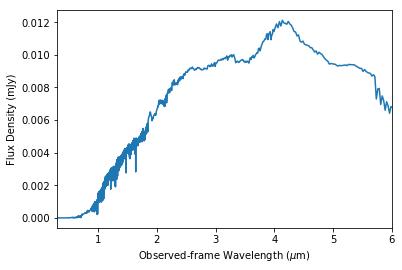

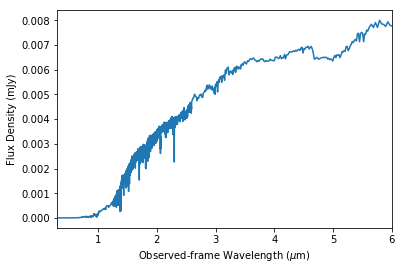

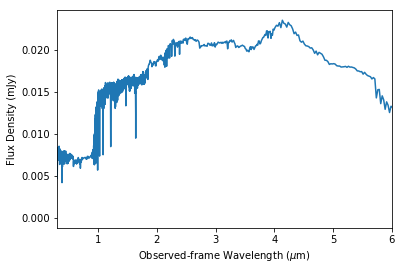

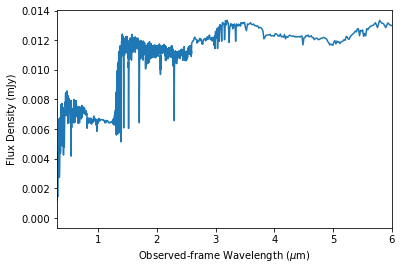

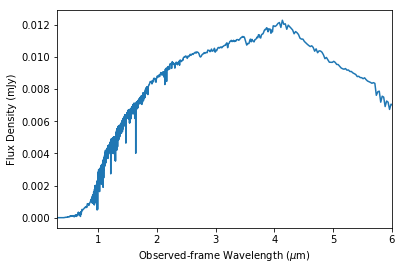

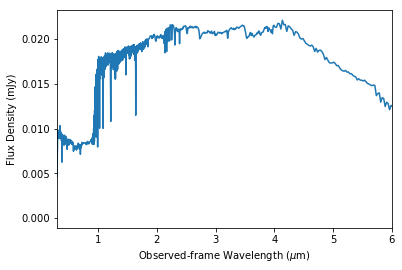

In [11]:
for ii in range(nspec):
    model = load_model(cat[ii])    
    
    obswave = sps.csp.wavelengths * (1 + cat['ZRED'][ii]) 
    cat['WAVELENGTH'][ii] = obswave / 1e4 * u.micron 
    
    obs = dict(
        filters = load_filters(filternames),
        wavelength = obswave
    )
    model_flux, model_phot, _ = model.mean_model(model.theta, obs, sps=sps)
    cat['FLUX'][ii] = model_flux * 10**(0.4 * 16.4) * u.mJy # maggies --> mJy
    cat['ABMAG'][ii, :] = -2.5 * np.log10(model_phot)

    if True:
        fig, ax = plt.subplots()
        ax.plot(cat['WAVELENGTH'][ii], cat['FLUX'][ii])
        ax.set_xlim(0.3, 6.0)
        ax.set_xlabel(r'Observed-frame Wavelength ($\mu$m)')
        ax.set_ylabel('Flux Density (mJy)')
cat

### Write out.

In [12]:
catfile = os.path.join(jwstdir, 'modelspec.fits')
print('Writing {}'.format(catfile))
cat.write(catfile, overwrite=True)

for ii in range(nspec):
    specfile = os.path.join(jwstdir, 'modelspec_{0:02d}.txt'.format(cat['ID'][ii]))
    print('Writing {}'.format(specfile))
    np.savetxt(specfile, np.vstack( (cat['WAVELENGTH'][ii].data, cat['FLUX'][ii]) ).T)
    #Table(cat[ii]).write(specfile, include_names=['WAVELENGHT', 'FLUX'], 
    #                     overwrite=True, format='ascii')

Writing /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec.fits
Writing /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_00.txt
Writing /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_01.txt
Writing /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_02.txt
Writing /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_03.txt
Writing /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_04.txt
Writing /Users/ioannis/research/projects/jwstclusters/etc/input/modelspec_05.txt
